In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 6): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Reason: Incompatible library version: image.so requires version 56.0.0 or later, but libpng16.16.dylib provides version 54.0.0'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Гіперпараметри
z_dim = 100
image_dim = 28 * 28
lr = 0.0002
batch_size = 128
num_epochs = 107

In [3]:
# Завантаження даних MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

100%|████████████████████████████| 9912422/9912422 [00:01<00:00, 9341962.15it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 14438104.15it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 6836823.53it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 4125276.91it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Генератор
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, image_dim),
            nn.Tanh()
        )
    def forward(self, x):
        return self.model(x)

In [5]:
# Дискримінатор
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

In [6]:
# Ініціалізація моделей та оптимізаторів
generator = Generator()
discriminator = Discriminator()
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr)

In [7]:
# Навчання
for epoch in range(num_epochs):
    for real_images, _ in train_loader:
        batch_size = real_images.shape[0]
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        
        # Навчання дискримінатора
        optimizer_d.zero_grad()
        real_outputs = discriminator(real_images.view(batch_size, -1))
        real_loss = criterion(real_outputs, real_labels)
        
        z = torch.randn(batch_size, z_dim)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs, fake_labels)
        
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()
        
        # Навчання генератора
        optimizer_g.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()

    print(f"Епоха [{epoch+1}/{num_epochs}], Дискримінатора Втрати: {d_loss.item():.4f}, Генератор Втрати: {g_loss.item():.4f}")

Епоха [1/107], Дискримінатора Втрати: 0.0623, Генератор Втрати: 4.3288
Епоха [2/107], Дискримінатора Втрати: 0.1370, Генератор Втрати: 3.2019
Епоха [3/107], Дискримінатора Втрати: 0.2837, Генератор Втрати: 4.0105
Епоха [4/107], Дискримінатора Втрати: 0.5485, Генератор Втрати: 3.4381
Епоха [5/107], Дискримінатора Втрати: 0.3791, Генератор Втрати: 3.8976
Епоха [6/107], Дискримінатора Втрати: 1.4746, Генератор Втрати: 1.5502
Епоха [7/107], Дискримінатора Втрати: 0.2603, Генератор Втрати: 3.4890
Епоха [8/107], Дискримінатора Втрати: 0.3154, Генератор Втрати: 3.2948
Епоха [9/107], Дискримінатора Втрати: 0.3650, Генератор Втрати: 3.7485
Епоха [10/107], Дискримінатора Втрати: 0.1208, Генератор Втрати: 4.8346
Епоха [11/107], Дискримінатора Втрати: 0.2786, Генератор Втрати: 4.3797
Епоха [12/107], Дискримінатора Втрати: 0.0537, Генератор Втрати: 5.6291
Епоха [13/107], Дискримінатора Втрати: 0.2157, Генератор Втрати: 3.5512
Епоха [14/107], Дискримінатора Втрати: 0.2102, Генератор Втрати: 6.0768
Е

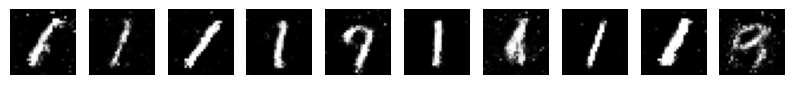

In [8]:
# Генерація та відображення зображень
z = torch.randn(10, z_dim)
generated_images = generator(z)

fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axes[i].imshow(generated_images[i].detach().view(28, 28), cmap='gray')
    axes[i].axis('off')
plt.show()